In [107]:
%matplotlib inline
import numpy as np
import nengo
import pylab

import nengo.utils.function_space
nengo.dists.Function = nengo.utils.function_space.Function
nengo.dists.Combined = nengo.utils.function_space.Combined
nengo.FunctionSpace = nengo.utils.function_space.FunctionSpace

### Function Spaces in Nengo

Here is proposed new utilities to add to Nengo to support function space representations.

The basic idea of a function space is that instead of representing vectors, we represent full functions (or even vector fields). 

#### What is a function?

Really, it's just a set of points.  For example, here's a guassian evaluated at a set of points:


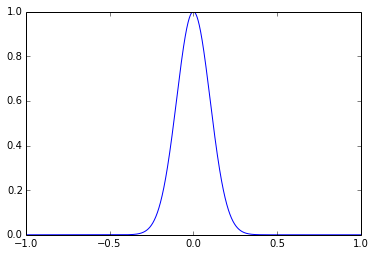

In [56]:
domain = np.linspace(-1, 1, 2000)

def gaussian(mag, mean, sd):
    return mag * np.exp(-(domain-mean)**2/(2*sd**2))

pylab.plot(domain, gaussian(mag=1, mean=0, sd=0.1))
pylab.show()

To define a function space, we need a bunch of different functions: for example, gaussians at different means and standard deviations and magnitudes.  We could generate this by randomly generating it ourselves:

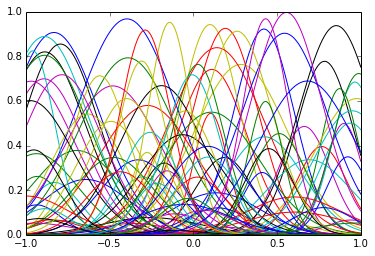

In [57]:
space = []
for i in range(100):
    space.append(gaussian(mag=np.random.uniform(0,1), 
                          mean=np.random.uniform(-1,1), 
                          sd=np.random.uniform(0.1, 0.3)))
pylab.plot(domain, np.array(space).T)
pylab.show()

Instead of generating this ourselves manually, this can be done with a new nengo.dists.Function class.  This is a subclass of nengo.dists.Distribution (just like nengo.dists.Uniform).

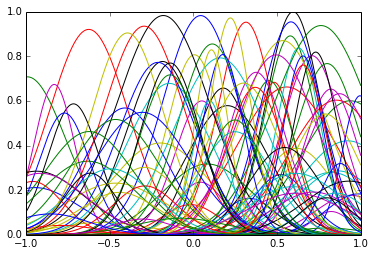

In [58]:
space = nengo.dists.Function(gaussian,
                             mag=nengo.dists.Uniform(0, 1),
                             mean=nengo.dists.Uniform(-1, 1),
                             sd=nengo.dists.Uniform(0.1, 0.3))
data = space.sample(100)
pylab.plot(domain, data.T)
pylab.show()

#### The naive way of putting this into Nengo

Well, if a function is just a bunch of points, we could just directly use this sort of distribution to define encoders and sample points.

Simulation finished in 0:00:01.                                                 


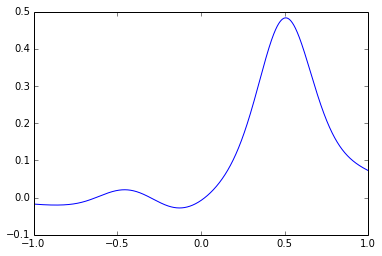

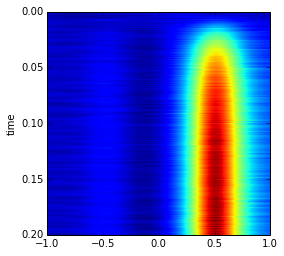

In [74]:
model = nengo.Network()
with model:
    stim = nengo.Node(gaussian(mag=1, mean=0.5, sd=0.1))
    ens = nengo.Ensemble(n_neurons=200, dimensions=2000,
                         encoders=space,
                         eval_points=space,
                        )
    nengo.Connection(stim, ens)
    probe_func = nengo.Probe(ens, synapse=0.03)
sim = nengo.Simulator(model)
sim.run(0.2)
pylab.plot(domain, sim.data[probe_func][-1])
pylab.figure()
pylab.imshow(sim.data[probe_func], extent=(-1,1,0.2,0), aspect=10.0)
pylab.ylabel('time')
pylab.show()

We can even compute functions on this function space.  Here is an example trying to find the peak of the represented function.

Simulation finished in 0:00:01.                                                 


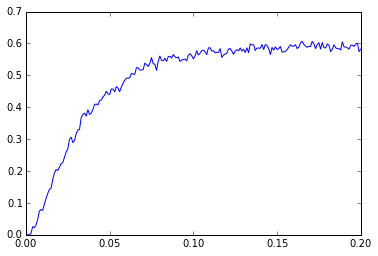

In [81]:
model = nengo.Network()
with model:
    stim = nengo.Node(gaussian(mag=1, mean=0.5, sd=0.2))
    ens = nengo.Ensemble(n_neurons=100, dimensions=2000,
                         encoders=space,
                         eval_points=space)
    nengo.Connection(stim, ens)
        
    peak = nengo.Ensemble(n_neurons=50, dimensions=1)
    def find_peak(x):
        return domain[np.argmax(x)]
    nengo.Connection(ens, peak, function=find_peak)
    
    probe_peak = nengo.Probe(peak, synapse=0.03)
    
sim = nengo.Simulator(model)
sim.run(0.2)
pylab.plot(sim.trange(), sim.data[probe_peak])
pylab.show()

#### The problem with the naive approach

It's fine and correct, but it's slow.  Why?  Well, think about what a Connection is doing now.  In a normal Nengo connection, we have N neurons and D dimensions, and we get this huge speedup because instead of an NxN connection weight matrix, we have an NxD decoder matrix and a DxN encoder matrix.

But in this situation, D starts being *bigger* than N!  In theory, we can let D go to infinity, and all of a sudden all of our nice encoder and decoder matrices explode up to ridiculous sizes.

#### Exploiting redundancy

So, what do we do instead?  Well, let's take advantage of the fact that those functions we are representing have *tons* of redundancy.  What we're going to do is to find a basis space for those functions such that we only have to represent a smaller number of dimensions.  This is done via SVD and taken care of by the new nengo.FunctionSpace object.

In [77]:
fs = nengo.FunctionSpace(
        nengo.dists.Function(gaussian,
                             mag=nengo.dists.Uniform(0, 1),
                             mean=nengo.dists.Uniform(-1, 1),
                             sd=nengo.dists.Uniform(0.1, 0.3)), 
        n_basis=20)

This will make a compressed function space for the given function.  The n_basis paramater indicates that we only want 10 dimensions in the internal representation.  Now we can use this to define our nengo model.

We use the functions fs.project and fs.reconstruct to convert into and out of this compressed space.  Importantly, fs.project can take a Distribution (including a Function, as above) or an array.  If it is given an array, it does the transformation.  If it is given a Distribution, then it returns a new Distribution that samples from the original distribution and does the projection when needed.  This means we can use it to set encoders and decoders!

Simulation finished in 0:00:01.                                                 


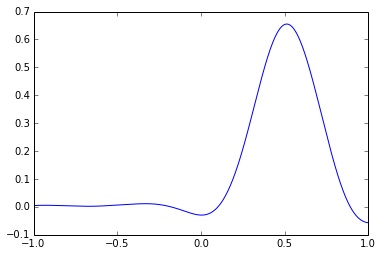

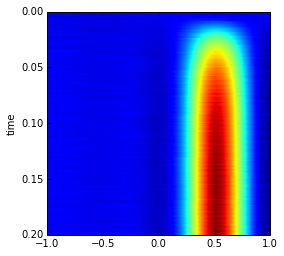

In [78]:
model = nengo.Network()
with model:
    stim = nengo.Node(fs.project(gaussian(mag=1, mean=0.5, sd=0.1)))
    ens = nengo.Ensemble(n_neurons=100, dimensions=fs.n_basis,
                         encoders=fs.project(space),
                         eval_points=fs.project(space))
    nengo.Connection(stim, ens)
    probe_func = nengo.Probe(ens, synapse=0.03)
sim = nengo.Simulator(model)
sim.run(0.2)
pylab.plot(domain, fs.reconstruct(sim.data[probe_func][-1]))
pylab.figure()
pylab.imshow(fs.reconstruct(sim.data[probe_func]), extent=(-1,1,0.2,0), aspect=10.0)
pylab.ylabel('time')
pylab.show()

This is now much faster, since all the matrices are reasonably sized now.  The cost is that you have to use fs.project() and fs.reconstruct() to go in and out of the compressed function space.



You can also still compute functions

Simulation finished in 0:00:01.                                                 


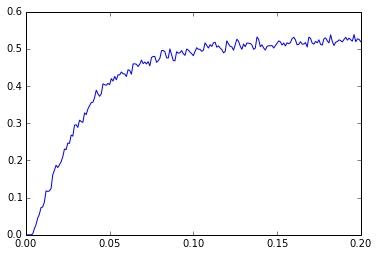

In [82]:
model = nengo.Network()
with model:
    stim = nengo.Node(fs.project(gaussian(mag=1, mean=0.5, sd=0.2)))
    ens = nengo.Ensemble(n_neurons=100, dimensions=fs.n_basis,
                         encoders=fs.project(space),
                         eval_points=fs.project(space))
    nengo.Connection(stim, ens)
        
    peak = nengo.Ensemble(n_neurons=50, dimensions=1)
    def find_peak(x):
        return domain[np.argmax(fs.reconstruct(x))]
    nengo.Connection(ens, peak, function=find_peak)
    
    probe_peak = nengo.Probe(peak, synapse=0.03)
    
sim = nengo.Simulator(model)
sim.run(0.2)
pylab.plot(sim.trange(), sim.data[probe_peak])
pylab.show()

#### Radius issues

Looking at the represented function, it looks like it works even better than before (less noise)!  Why?

Mostly because in the initial naive version we forgot to worry about the radius.  The encoders that we specified in the naive approach got automatically scaled to unit length, and the vectors we were feeding in for sample points were much larger than unit length.  So most of the neurons are spending a lot of their time very saturated (since the gain and bias calculations don't know about the changed radius).  We could have rescaled the eval_points and put in a radius to make it equivalent.

(Note: this would be slightly easier if Ensembles had a scale_eval_points parameters, like Connections do)

Simulation finished in 0:00:01.                                                 


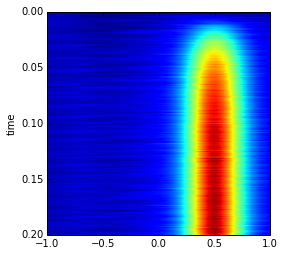

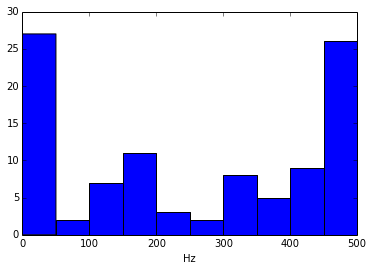

In [83]:
model = nengo.Network()
with model:
    stim = nengo.Node(gaussian(mag=1, mean=0.5, sd=0.1))
    ens = nengo.Ensemble(n_neurons=100, dimensions=2000,
                         encoders=space,
                         eval_points=space,
                         radius=radius
                        )
    nengo.Connection(stim, ens)
    probe_func = nengo.Probe(ens, synapse=0.03)
    probe_spikes = nengo.Probe(ens.neurons)
    
sim = nengo.Simulator(model)
sim.run(0.2)
pylab.imshow(sim.data[probe_func], extent=(-1,1,0.2,0), aspect=10.0)
pylab.ylabel('time')
pylab.figure()
pylab.hist(np.mean(sim.data[probe_spikes], axis=0))
pylab.xlabel('Hz')
pylab.show()

Simulation finished in 0:00:01.                                                 


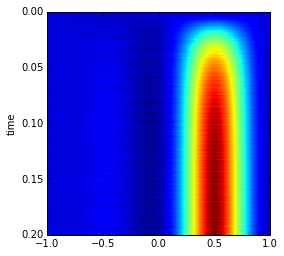

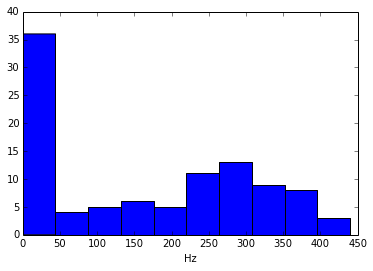

In [84]:
radius = np.mean(np.linalg.norm(space.sample(10), axis=1))

model = nengo.Network()
with model:
    stim = nengo.Node(gaussian(mag=1, mean=0.5, sd=0.1))
    ens = nengo.Ensemble(n_neurons=100, dimensions=2000,
                         encoders=space,
                         eval_points=space.sample(5000)/radius,
                         radius=radius
                        )
    nengo.Connection(stim, ens)
    probe_func = nengo.Probe(ens, synapse=0.03)
    probe_spikes = nengo.Probe(ens.neurons)
    
sim = nengo.Simulator(model)
sim.run(0.2)
pylab.imshow(sim.data[probe_func], extent=(-1,1,0.2,0), aspect=10.0)
pylab.ylabel('time')
pylab.figure()
pylab.hist(np.mean(sim.data[probe_spikes], axis=0))
pylab.xlabel('Hz')
pylab.show()

#### Multiple Distributions

It should be noted that there are three different distributions in play here.  The distribution used to define the space, the distribution for the encoders, and the distribution for the evaluation points.  These can be all different.  I believe we will often want to have the distribution used by the space to be the same as the eval_points, but the encoders are generally pretty different.  For example, I might have encoders that are all gaussians of the same height and width.

Simulation finished in 0:00:01.                                                 


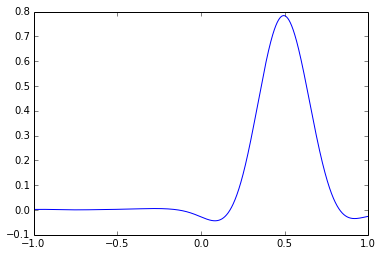

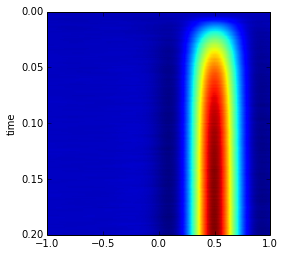

In [90]:
fs = nengo.FunctionSpace(
        nengo.dists.Function(gaussian,
                             mag=nengo.dists.Uniform(0, 1),
                             mean=nengo.dists.Uniform(-1, 1),
                             sd=nengo.dists.Uniform(0.1, 0.3)), 
        n_basis=20)

model = nengo.Network()
with model:
    stim = nengo.Node(fs.project(gaussian(mag=1, mean=0.5, sd=0.1)))    
    ens = nengo.Ensemble(n_neurons=500, dimensions=fs.n_basis)
    ens.encoders = fs.project(
                        nengo.dists.Function(gaussian,
                        mean=nengo.dists.Uniform(-1, 1),
                        sd=0.1,
                        mag=1))
    ens.eval_points = fs.project(fs.space)
    nengo.Connection(stim, ens)
    probe_func = nengo.Probe(ens, synapse=0.03)
sim = nengo.Simulator(model)
sim.run(0.2)
pylab.plot(domain, fs.reconstruct(sim.data[probe_func][-1]))
pylab.figure()
pylab.imshow(fs.reconstruct(sim.data[probe_func]), extent=(-1,1,0.2,0), aspect=10.0)
pylab.ylabel('time')
pylab.show()

#### Nengo GUI integration

There are two useful tools that help for doing stuff with nengo_gui.  For plotting the function, there is an fs.make_plot_node function.  For input, there is an fs.make_stimulus_node that gives you a node that'll let you control the variables passed in to the underlying function.  For example:

In [93]:
model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=500, dimensions=fs.n_basis)
    ens.encoders = fs.project(fs.space)
    ens.eval_points = fs.project(fs.space)
    
    # input
    stim = fs.make_stimulus_node(gaussian, 3)
    nengo.Connection(stim, ens)    
    stim_control = nengo.Node([1, 0, 0.2])
    nengo.Connection(stim_control, stim)
    
    #output
    plot = fs.make_plot_node(domain=domain)
    nengo.Connection(ens, plot, synapse=0.1)
    
from nengo_gui.ipython import IPythonViz
IPythonViz(model, cfg='funcspace.cfg')

c:\users\terry\documents\github\nengo_gui\nengo_gui\ipython.py:58: ConfigReuseWarning: Reusing config. Only the most recent visualization will update the config.
  "Reusing config. Only the most recent visualization will "


The output display support multiple plots overlaid on top of each other, and has configurable number of points drawn

In [95]:
model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=500, dimensions=fs.n_basis)
    ens.encoders = fs.project(space)
    ens.eval_points = fs.project(fs.space)
    
    # input
    stim = fs.make_stimulus_node(gaussian, 3)
    nengo.Connection(stim, ens)    
    stim_control = nengo.Node([1, 0, 0.2])
    nengo.Connection(stim_control, stim)
    
    #output
    plot = fs.make_plot_node(domain=domain, n_pts=50, lines=2)
    nengo.Connection(ens, plot[:fs.n_basis], synapse=0.1)
    nengo.Connection(stim, plot[fs.n_basis:], synapse=0.1)
    
from nengo_gui.ipython import IPythonViz
IPythonViz(model, cfg='funcspace2.cfg')

#### Multidimensional representations

There is nothing restricting this code to 1 dimensional functions.  For example, here is a 2D bump:

In [103]:
domain = np.random.uniform(-1, 1, size=(1000, 2))

def gaussian2d(meanx, meany, sd):
    return np.exp(-((domain[:,0]-meanx)**2+(domain[:,1]-meany)**2)/(2*sd**2))

fs = nengo.FunctionSpace(
        nengo.dists.Function(gaussian2d,
                             meanx=nengo.dists.Uniform(-1, 1), 
                             meany=nengo.dists.Uniform(-1, 1), 
                             sd=nengo.dists.Uniform(0.1, 0.7)),
        
        n_basis=50)

model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=500, dimensions=fs.n_basis)
    ens.encoders = fs.project(fs.space)
    ens.eval_points = fs.project(fs.space)
    
    stimulus = nengo.Node(fs.project(gaussian2d(0,0,0.2)))
    nengo.Connection(stimulus, ens)
    
    probe = nengo.Probe(ens, synapse=0.01)

sim = nengo.Simulator(model)
sim.run(0.2)

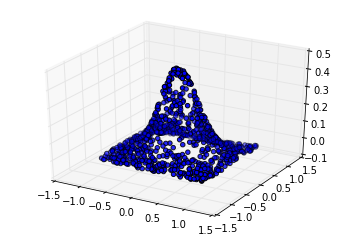

In [105]:
from mpl_toolkits.mplot3d import Axes3D
fig = pylab.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(domain[:,0], domain[:,1], fs.reconstruct(sim.data[probe][-1]))
pylab.show()

There is no nengo_gui support for displaying anything other than 1d functions (yet).

Also, notice that you could also represent 2 1-D functions just by concatenating their output.  As long as the function passed in to nengo.dists.Function just returns a vector, everything should work.


#### Combining functions and scalars

Sometimes, we might want to do both functions and normal NEF vector representations in the same population.  For example, here I want to represent both a function and a shift that should be applied to that function.

To do this, we need a way of specifying the encoders and eval_points of the combined representation.  This is done with a new nengo.dists.Combined which takes a list of distributions and concatenates them together.  When doing this concatenation, we need to know how many dimensions are used for each.  So, if I have 20-D done with a function space and 2-D done with a normal representations, I'd do

```
nengo.dists.Combined(
    [fs.project(fs.space), nengo.dists.UniformHypersphere(surface=False)], 
    [fs.n_basis,2])
```

i'm not all that happy with this syntax yet, and I think there's some tweaking still needed in terms of the correct scaling that should be applied, but it mostly works:

In [117]:
domain = np.linspace(-1, 1, 2000)

def gaussian(mag, mean, sd):
    return mag * np.exp(-(domain-mean)**2/(2*sd**2))

fs = nengo.FunctionSpace(
        nengo.dists.Function(gaussian,
                             mag=nengo.dists.Uniform(0, 1),
                             mean=nengo.dists.Uniform(-1, 1),
                             sd=nengo.dists.Uniform(0.1, 0.3)), 
        n_basis=40)

model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=2000, dimensions=fs.n_basis+1)
    ens.encoders = nengo.dists.Combined(
                        [fs.project(fs.space), nengo.dists.UniformHypersphere(surface=True)], 
                        [fs.n_basis,1])    
    ens.eval_points = nengo.dists.Combined(
                        [fs.project(fs.space), nengo.dists.UniformHypersphere(surface=False)], 
                        [fs.n_basis,1])

    stim_shift = nengo.Node([0])
    nengo.Connection(stim_shift, ens[-1])
    
    # input
    stim = fs.make_stimulus_node(gaussian, 3)
    nengo.Connection(stim, ens[:-1])    
    stim_control = nengo.Node([1, 0, 0.13])
    nengo.Connection(stim_control, stim)
    
    #output
    plot = fs.make_plot_node(domain=domain)
    
    def shift_func(x):
        shift = int(x[-1]*500)
        return fs.project(np.roll(fs.reconstruct(x[:-1]), shift))
    
    nengo.Connection(ens, plot, synapse=0.1, function=shift_func)
    
from nengo_gui.ipython import IPythonViz
IPythonViz(model, cfg='funcspace3.cfg')
